In [1]:
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
import pandas as pd
import gdal
import rasterio as rt
from rasterio.plot import show

In [2]:
#An array of RGB and landcover class
classArray = np.load('../Data/Txt/classArray.npy')
print('1st column denotes Red Band \n 2nd Column denotes Green \n 3rd Column denotes Blue \n 4th column denotes Landcover class designation')
print(classArray[:5])

1st column denotes Red Band 
 2nd Column denotes Green 
 3rd Column denotes Blue 
 4th column denotes Landcover class designation
[[15. 56. 40. 40.]
 [10. 51. 35. 40.]
 [13. 63. 42. 40.]
 [13. 65. 42. 40.]
 [18. 70. 47. 40.]]


In [3]:
#Create pandas dataframe from the numpy array
df = pd.DataFrame(classArray)

In [4]:
df.head()

,0,1,2,3
0,15.0,56.0,40.0,40.0
1,10.0,51.0,35.0,40.0
2,13.0,63.0,42.0,40.0
3,13.0,65.0,42.0,40.0
4,18.0,70.0,47.0,40.0


In [5]:
#Rename the pandas dataframe columns
new_cols = ['red', 'green', 'blue', 'ref']
df.columns = new_cols

In [6]:
df.head()

,red,green,blue,ref
0,15.0,56.0,40.0,40.0
1,10.0,51.0,35.0,40.0
2,13.0,63.0,42.0,40.0
3,13.0,65.0,42.0,40.0
4,18.0,70.0,47.0,40.0


In [7]:
#Change the column order
df =df[["ref","red","green","blue"]]

In [47]:
df.head()

,ref,red,green,blue
0,40.0,15.0,56.0,40.0
1,40.0,10.0,51.0,35.0
2,40.0,13.0,63.0,42.0
3,40.0,13.0,65.0,42.0
4,40.0,18.0,70.0,47.0


In [9]:
#Save the dataset as a csv
df.to_csv('../Data/Rst/training_dataset.csv', header = True, index= False)

In [10]:
#Divide the data into training and testing
#Load the independent variables Red, Green, Blue
X = df.iloc[:, 1:4].values
#Load the dependent variable, Landcover class value
y = df.iloc[:, 0].values

In [11]:
print(X)

[[15. 56. 40.]
 [10. 51. 35.]
 [13. 63. 42.]
 ...
 [24. 63. 44.]
 [25. 62. 44.]
 [17. 54. 36.]]


In [12]:
#Divide the data into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)

In [13]:
#Fit the NaviesBayes classifier to the training data
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

In [14]:
#Predict the training data
y_pred = clf.predict(X_test)

In [15]:
#Confusion matrics
from sklearn.metrics import confusion_matrix
confMatrix = confusion_matrix(y_test,y_pred)
confMatrix

array([[238,   0,  12,   1],
       [ 10, 111,   3,   0],
       [  2,   6,  45,   8],
       [  0,   0,  39, 302]], dtype=int64)

In [16]:
#R2 score
from sklearn import metrics
r_square_rf = metrics.r2_score(y_test, y_pred)
print('The r-squared =', r_square_rf) #The score looks good

The r-squared = 0.9039915584794386


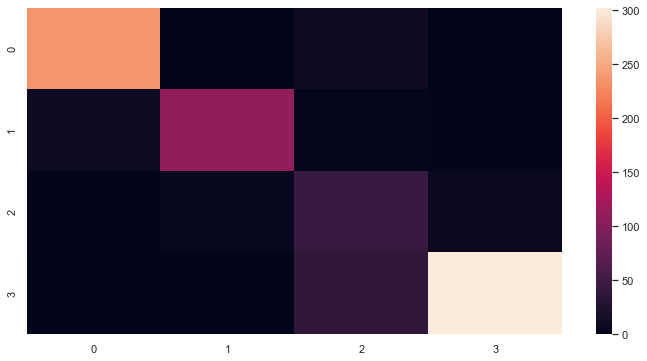

In [17]:
#Plot the confusion matrix
#We can see that the landcover class 2 has a strong affinity with 3, in that case two our classes pixels will be mixed
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
fig= plt.figure(figsize=(12,6))
ax = sns.heatmap(confMatrix)

In [31]:
#Apply the model on the whole image
with rt.open('../Data/Rst/riverImage2.tif') as dst:
    bands = dst.read()

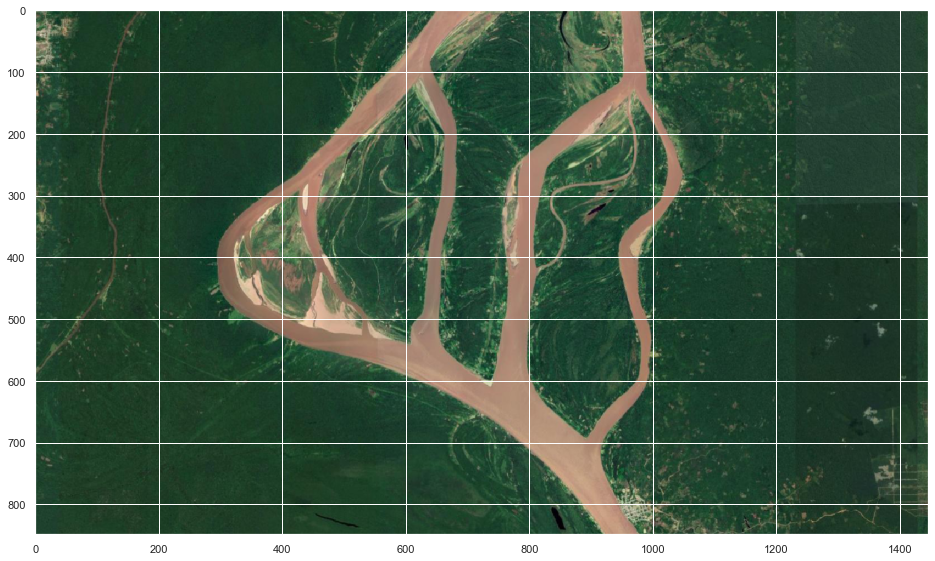

<AxesSubplot:>

In [32]:
plt.figure(figsize= (16,12))
show(bands)

In [46]:
#3D array
# 4 bands, 849 rows and 1446 columns
print(bands.shape)

(4, 849, 1446)


In [38]:
#Stack the RGB bands
#Which will genereate a 3D array, with rows, cols and bands, but we will change the axis of the bands
array = np.stack(bands[0:3,:,:], axis= 2)
array.shape

(849, 1446, 3)

In [41]:
#Remember: we need a 2D array of size [n_samples x n_features] for Sk-learn
#Convert the 3d stack array into 2D
array = np.reshape(array, [dst.height*dst.width, 3])
array.shape

(1227654, 3)

In [43]:
#Now we have a 2d array, which is ready to be fed to the SK-learn model
print(array)

[[ 70  86  59]
 [143 151 126]
 [182 181 157]
 ...
 [ 35  70  46]
 [ 33  68  44]
 [ 32  67  43]]


In [21]:
df2 = pd.DataFrame(array)
df2.head()

,0,1,2
0,70,86,59
1,143,151,126
2,182,181,157
3,184,176,155
4,184,176,155


In [22]:
#Predict the landcover classes for the whole image
pred = clf.predict(array)

In [23]:
#Reshape the array
estimation = pred.reshape((849, 1446))

Text(0.5, 1.0, 'Classified Land Cover Map')

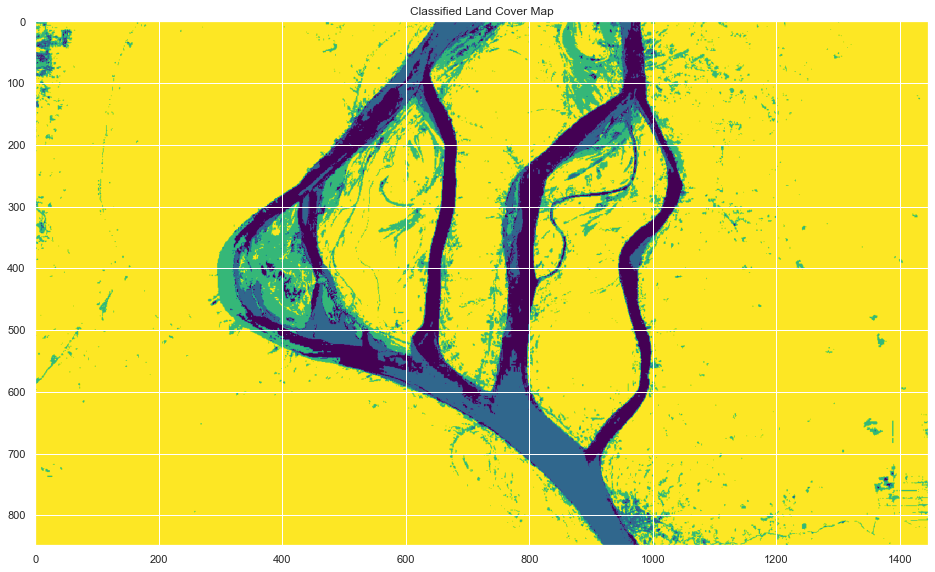

In [24]:
#The classification results might be readily improved by integrating more bands, such as NIR, SWIR 1 and 2
plt.figure(figsize = (16,20))
plt.imshow(estimation, cmap = 'viridis')
plt.title('Classified Land Cover Map')

In [25]:
estimation.shape

(849, 1446)

In [26]:
estimation

array([[40., 30., 20., ..., 40., 40., 40.],
       [40., 30., 20., ..., 40., 40., 40.],
       [40., 30., 20., ..., 40., 40., 40.],
       ...,
       [40., 40., 40., ..., 40., 40., 40.],
       [40., 40., 40., ..., 40., 40., 40.],
       [40., 40., 40., ..., 40., 40., 40.]], dtype=float32)

In [27]:
#Function to save the Geotiff
def createGeotiff(outRaster, estimation_array, geo_transform, projection):
    driver = gdal.GetDriverByName('GTIFF')
    rows, cols = estimation_array.shape
    rasterDS = driver.Create(outRaster, cols, rows, 1, gdal.GDT_Float32)
    rasterDS.SetGeoTransform(geo_transform)
    rasterDS.SetProjection(projection)
    band = rasterDS.GetRasterBand(1)
    band.WriteArray(estimation_array)
    rasterDS= None

In [28]:
#Save the classified landcover image as a tiff
inpRaster = '../Data/Rst/riverImage2.tif'
outRaster = '../Data/Rst/NB_classified.tif'
ds = gdal.Open(inpRaster, gdal.GA_ReadOnly)
rows = ds.RasterYSize
cols = ds.RasterXSize
bands = ds.RasterCount
geo_transform = ds.GetGeoTransform()
projection = ds.GetProjectionRef()
array = ds.ReadAsArray()
ds= None

createGeotiff(outRaster, estimation, geo_transform, projection)